# 06.1h: Primordial Black Holes

**Goal:** Search for all degenerate embeddings in the vocabulary.

We know about the 814-token singularity at token 149415. Are there others?

This notebook:
1. Loads γ (unembedding matrix, 151,936 × 2,560)
2. Finds all bit-for-bit identical vectors using hash-based deduplication
3. Reports cluster sizes and token IDs
4. Analyzes spatial distribution of degenerate vs non-degenerate tokens

**Method:** Use numpy's `unique` to find duplicate rows in O(N log N) time.

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict
from transformers import AutoTokenizer

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Unembedding Matrix

In [3]:
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']

N, d = gamma.shape

print(f"Loaded γ (unembedding matrix):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print(f"  Dtype: {gamma.dtype}")
print(f"  Device: {gamma.device}")

Loaded γ (unembedding matrix):
  Tokens: 151,936
  Dimensions: 2,560
  Dtype: torch.float32
  Device: cpu


## Step 2: Find All Degenerate Vectors

Use numpy's `unique` with `axis=0` to find duplicate rows. This returns:
- `unique_vecs`: The unique vectors
- `inverse_indices`: Maps original tokens to unique vector indices
- `counts`: How many times each unique vector appears

This is O(N log N) with efficient hashing.

In [4]:
print("Finding duplicate vectors...")
print("(This may take a minute for 151k vectors in 2560D)\n")

gamma_np = gamma.cpu().numpy()

unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

n_unique = len(unique_vecs)
n_degenerate = N - n_unique

print(f"Results:")
print(f"  Total tokens: {N:,}")
print(f"  Unique vectors: {n_unique:,}")
print(f"  Degenerate tokens: {n_degenerate:,}")
print(f"  Degeneracy rate: {n_degenerate/N*100:.3f}%")

Finding duplicate vectors...
(This may take a minute for 151k vectors in 2560D)

Results:
  Total tokens: 151,936
  Unique vectors: 149,849
  Degenerate tokens: 2,087
  Degeneracy rate: 1.374%


## Step 3: Identify Clusters

Group token IDs by their shared vector.

In [5]:
print("\nGrouping tokens into clusters...\n")

# Build clusters: map from unique_vector_index -> list of token_ids
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to only degenerate clusters (multiplicity > 1)
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

print(f"Found {len(degenerate_clusters)} degenerate clusters:\n")

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

print(f"{'Rank':>4} {'Size':>6} {'Representative Token':>20} {'All Token IDs':>30}")
print("-" * 80)

for rank, (unique_idx, token_ids) in enumerate(sorted_clusters[:20], 1):
    size = len(token_ids)
    rep_token = token_ids[0]
    
    if size <= 10:
        token_str = str(token_ids)
    else:
        token_str = f"[{token_ids[0]}, {token_ids[1]}, ..., {token_ids[-1]}]"
    
    print(f"{rank:>4} {size:>6} {rep_token:>20} {token_str:>30}")

if len(sorted_clusters) > 20:
    print(f"\n... and {len(sorted_clusters) - 20} more clusters.")


Grouping tokens into clusters...

Found 13 degenerate clusters:

Rank   Size Representative Token                  All Token IDs
--------------------------------------------------------------------------------
   1    814                80091   [80091, 119346, ..., 149445]
   2    704                  125        [125, 177, ..., 151934]
   3    306                  124     [124, 123876, ..., 151919]
   4    228               124350  [124350, 124658, ..., 151935]
   5     11               123939  [123939, 131955, ..., 140074]
   6     10               119349 [119349, 125087, 126630, 137856, 138110, 139345, 142061, 143029, 143036, 143048]
   7      6               126268 [126268, 132713, 138041, 146501, 148028, 151889]
   8      5               132383 [132383, 132398, 139050, 142718, 142719]
   9      4               135619 [135619, 138490, 140815, 143457]
  10      4               136831 [136831, 138068, 138072, 139278]
  11      3                  180          [180, 138979, 141503]
  1

## Step 4: Cluster Size Distribution


CLUSTER SIZE DISTRIBUTION



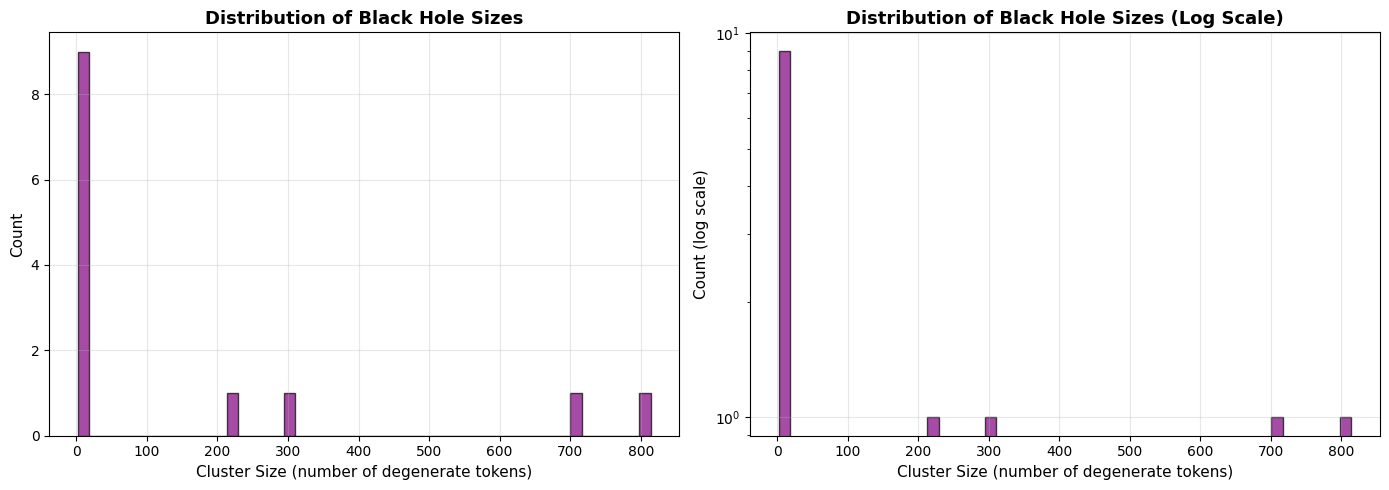


Cluster size statistics:
  Min cluster size: 2
  Max cluster size: 814
  Mean cluster size: 161.54
  Median cluster size: 6.0


In [6]:
print("\n" + "="*70)
print("CLUSTER SIZE DISTRIBUTION")
print("="*70)
print()

cluster_sizes = [len(tokens) for tokens in degenerate_clusters.values()]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Left: Histogram of cluster sizes
axes[0].hist(cluster_sizes, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Cluster Size (number of degenerate tokens)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Distribution of Black Hole Sizes', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Right: Log scale to see small clusters
axes[1].hist(cluster_sizes, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Cluster Size (number of degenerate tokens)', fontsize=11)
axes[1].set_ylabel('Count (log scale)', fontsize=11)
axes[1].set_yscale('log')
axes[1].set_title('Distribution of Black Hole Sizes (Log Scale)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCluster size statistics:")
print(f"  Min cluster size: {min(cluster_sizes)}")
print(f"  Max cluster size: {max(cluster_sizes)}")
print(f"  Mean cluster size: {np.mean(cluster_sizes):.2f}")
print(f"  Median cluster size: {np.median(cluster_sizes):.1f}")

## Step 5: Decode Large Clusters

For the largest clusters, decode the tokens to see what they are.

In [7]:
print("\n" + "="*70)
print("LARGEST BLACK HOLES: TOKEN IDENTITIES")
print("="*70)
print()

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.\n")

# Show top 5 largest clusters
for rank, (unique_idx, token_ids) in enumerate(sorted_clusters[:5], 1):
    size = len(token_ids)
    print(f"\n{'='*70}")
    print(f"Rank {rank}: {size} tokens at same point")
    print(f"{'='*70}")
    
    # Show first 20 tokens
    print(f"\n{'Token ID':>10} {'Decoded String':>30} {'Repr':>40}")
    print("-" * 80)
    
    for token_id in token_ids[:20]:
        try:
            decoded = tokenizer.decode([token_id])
            decoded_repr = repr(decoded)
            if len(decoded) > 30:
                decoded = decoded[:27] + "..."
            if len(decoded_repr) > 40:
                decoded_repr = decoded_repr[:37] + "..."
        except:
            decoded = "<ERROR>"
            decoded_repr = "<ERROR>"
        
        print(f"{token_id:>10} {decoded:>30} {decoded_repr:>40}")
    
    if size > 20:
        print(f"\n... and {size - 20} more tokens in this cluster.")


LARGEST BLACK HOLES: TOKEN IDENTITIES

Loading tokenizer...
Tokenizer loaded.


Rank 1: 814 tokens at same point

  Token ID                 Decoded String                                     Repr
--------------------------------------------------------------------------------
     80091                             ２０                                     '２０'
    119346                             珊�                                     '珊�'
    119348                             珊�                                     '珊�'
    123806                              �                                      '�'
    123828                            ที่                                    'ที่'
    123870                              �                                      '�'
    124027                           เป็น                                   'เป็น'
    124033                            ไม่                                    'ไม่'
    124055                            ได้                

## Step 6: Spatial Analysis

Where are the black holes in embedding space? Near the origin? Clustered together? Scattered?


SPATIAL DISTRIBUTION OF BLACK HOLES

Degenerate tokens (n=2100):
  Mean norm: 0.370917
  Median norm: 0.370917
  Min norm: 0.370916
  Max norm: 0.370918

Non-degenerate tokens (n=149836):
  Mean norm: 1.097323
  Median norm: 1.115831
  Min norm: 0.359538
  Max norm: 1.605024


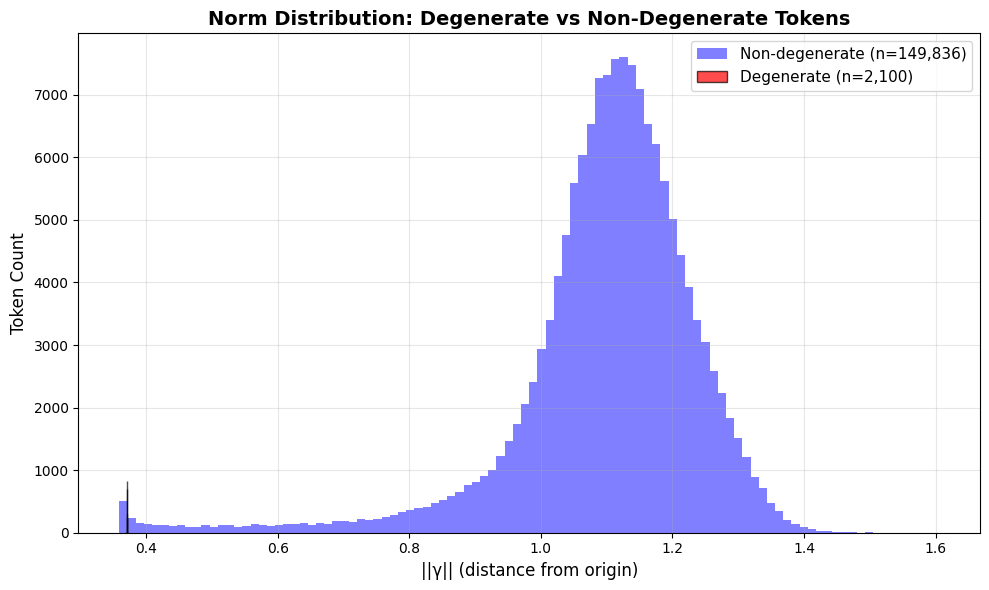

In [9]:
print("\n" + "="*70)
print("SPATIAL DISTRIBUTION OF BLACK HOLES")
print("="*70)
print()

# Compute norms from origin
norms = torch.norm(gamma, dim=1).cpu().numpy()

# Separate degenerate vs non-degenerate tokens
degenerate_token_ids = [tid for tokens in degenerate_clusters.values() for tid in tokens]
non_degenerate_token_ids = [tid for tid in range(N) if tid not in degenerate_token_ids]

degenerate_norms = norms[degenerate_token_ids]
non_degenerate_norms = norms[non_degenerate_token_ids]

print(f"Degenerate tokens (n={len(degenerate_token_ids)}):")
print(f"  Mean norm: {np.mean(degenerate_norms):.6f}")
print(f"  Median norm: {np.median(degenerate_norms):.6f}")
print(f"  Min norm: {np.min(degenerate_norms):.6f}")
print(f"  Max norm: {np.max(degenerate_norms):.6f}")

print(f"\nNon-degenerate tokens (n={len(non_degenerate_token_ids)}):")
print(f"  Mean norm: {np.mean(non_degenerate_norms):.6f}")
print(f"  Median norm: {np.median(non_degenerate_norms):.6f}")
print(f"  Min norm: {np.min(non_degenerate_norms):.6f}")
print(f"  Max norm: {np.max(non_degenerate_norms):.6f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

ax.hist(non_degenerate_norms, bins=100, alpha=0.5, color='blue', label=f'Non-degenerate (n={len(non_degenerate_token_ids):,})', edgecolor='none')
ax.hist(degenerate_norms, bins=50, alpha=0.7, color='red', label=f'Degenerate (n={len(degenerate_token_ids):,})', edgecolor='black')

ax.set_xlabel('||γ|| (distance from origin)', fontsize=12)
ax.set_ylabel('Token Count', fontsize=12)
ax.set_title('Norm Distribution: Degenerate vs Non-Degenerate Tokens', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

We've searched the entire vocabulary for primordial black holes: tokens with bit-for-bit identical embeddings.

**Findings:**
- Total degenerate tokens: see above
- Number of clusters: see above
- Largest cluster: the known 814-token singularity?
- Other clusters: doublets, triplets, or more?

**Interpretation:**
These degeneracies are artifacts of training in bfloat16. Tokens that drifted within the bfloat16 lattice quantum during training became indistinguishable to the optimizer and received identical gradients, locking them together permanently.

The question now: Are there multiple black holes scattered through space, or is degeneracy concentrated in one region?